# Validation Service Benchmarks


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from pprint import pprint

### Configuration

In [4]:
nmon_metric_options = [
    ("timestamp", "Timestamp MS since Epoch", [0, 80], "timestamp"), #0
    ("CPU_ALL:User%", "CPU Total: User %", [0,100], "cpu_all_user_percent"), # 1
    ("CPU_ALL:Sys%", "CPU Total: System %", [0,100], "cpu_all_system_percent"), # 2
    ("MEM:memtotal", "Memory MB: Total", [0,65000], "mem_MB_total"), #3
    ("MEM:hightotal", "Memory MB: High Total", [0,65000], "mem_MB_high_total"), #4
    ("MEM:lowtotal", "Memory MB: Low Total", [0,65000], "mem_MB_low_total"), #5
    ("MEM:swapfree", "Memory MB: Swap Free", [0,1000], "mem_MB_swap_free"), #6
    ("MEM:active", "Memory MB: Active", [0,65000], "mem_MB_active"), #7
    ("MEM:inactive", "Memory MB: Inactive", [0,65000], "mem_MB_inactive"), #8
    ("NET:eno1-write-KB/s", "Network Write KB/s", [0,1000], "net_io_write_KBps"), #9
    ("NET:eno1-read-KB/s", "Network Read KB/s", [0,1000], "net_io_read_KBps"), #10
    ("DISKBUSY:sda", "Disk Busy %: /dev/sda", [0,100], "disk_io_busy_percent"), #11
    ("DISKREAD:sda", "Disk Read KB/s: /dev/sda", [0,10000], "disk_io_read_KBps"), #12
    ("DISKWRITE:sda", "Disk Write KB/s: /dev/sda", [0,10000], "disk_io_write_KBps"), #13
    ("VM:pgfault", "Paging and Virtual Memory: Page Faults", [0,100], "virt_mem_page_faults") #14
]

free_mem_metrics = [
    ("total", "Memory Total", [0,67000], "mem_total_MB"), # 0
    ("used", "Memory Used", [0,67000], "mem_used_MB"), # 1
    ("free", "Memory Free", [0,67000], "mem_free_MB"), #2
    ("shared", "Memory Shared", [0,67000], "mem_shared_MB"), #3
    ("buff/cache", "Memory Buffer/Cache", [0,67000], "buff_cache_MB"), # 4
    ("available", "Memory Available", [0,67000], "mem_available_MB") # 5
]

possible_experiments = [
    "static_budget/no_budget/read_primary_shard",
    "static_budget/no_budget/read_local_mongod",
    "static_budget/sample_rate/10_percent/read_local_mongod",
    "static_budget/sample_rate/20_percent/read_local_mongod",
    "static_budget/sample_rate/50_percent/read_local_mongod",
    "static_budget/total_limit/20M/read_local_mongod"
]

experiments = [
    "no_budgets/job_mode_multiprocessing",
]

chosen_metric = nmon_metric_options[1]
metric_header = chosen_metric[0]
metric_name = chosen_metric[1]
y_axis_limits = chosen_metric[2]
metric_file_suffix = chosen_metric[3]

experiment_dfs = []
for experiment in experiments:
    dataframes = []
    for i in range(0, 25):
        machine_id = f"lattice-{150+i}"
        filename = f"{i}-{machine_id}.nmon.csv"
        # filename = f"{machine_id}_free.csv"
        filepath = f"{experiment}/{filename}"
        dataframes.append(pd.read_csv(filepath, header=0).pop(metric_header))
    experiment_dfs.append((experiment, dataframes))


### Cluster Plotting

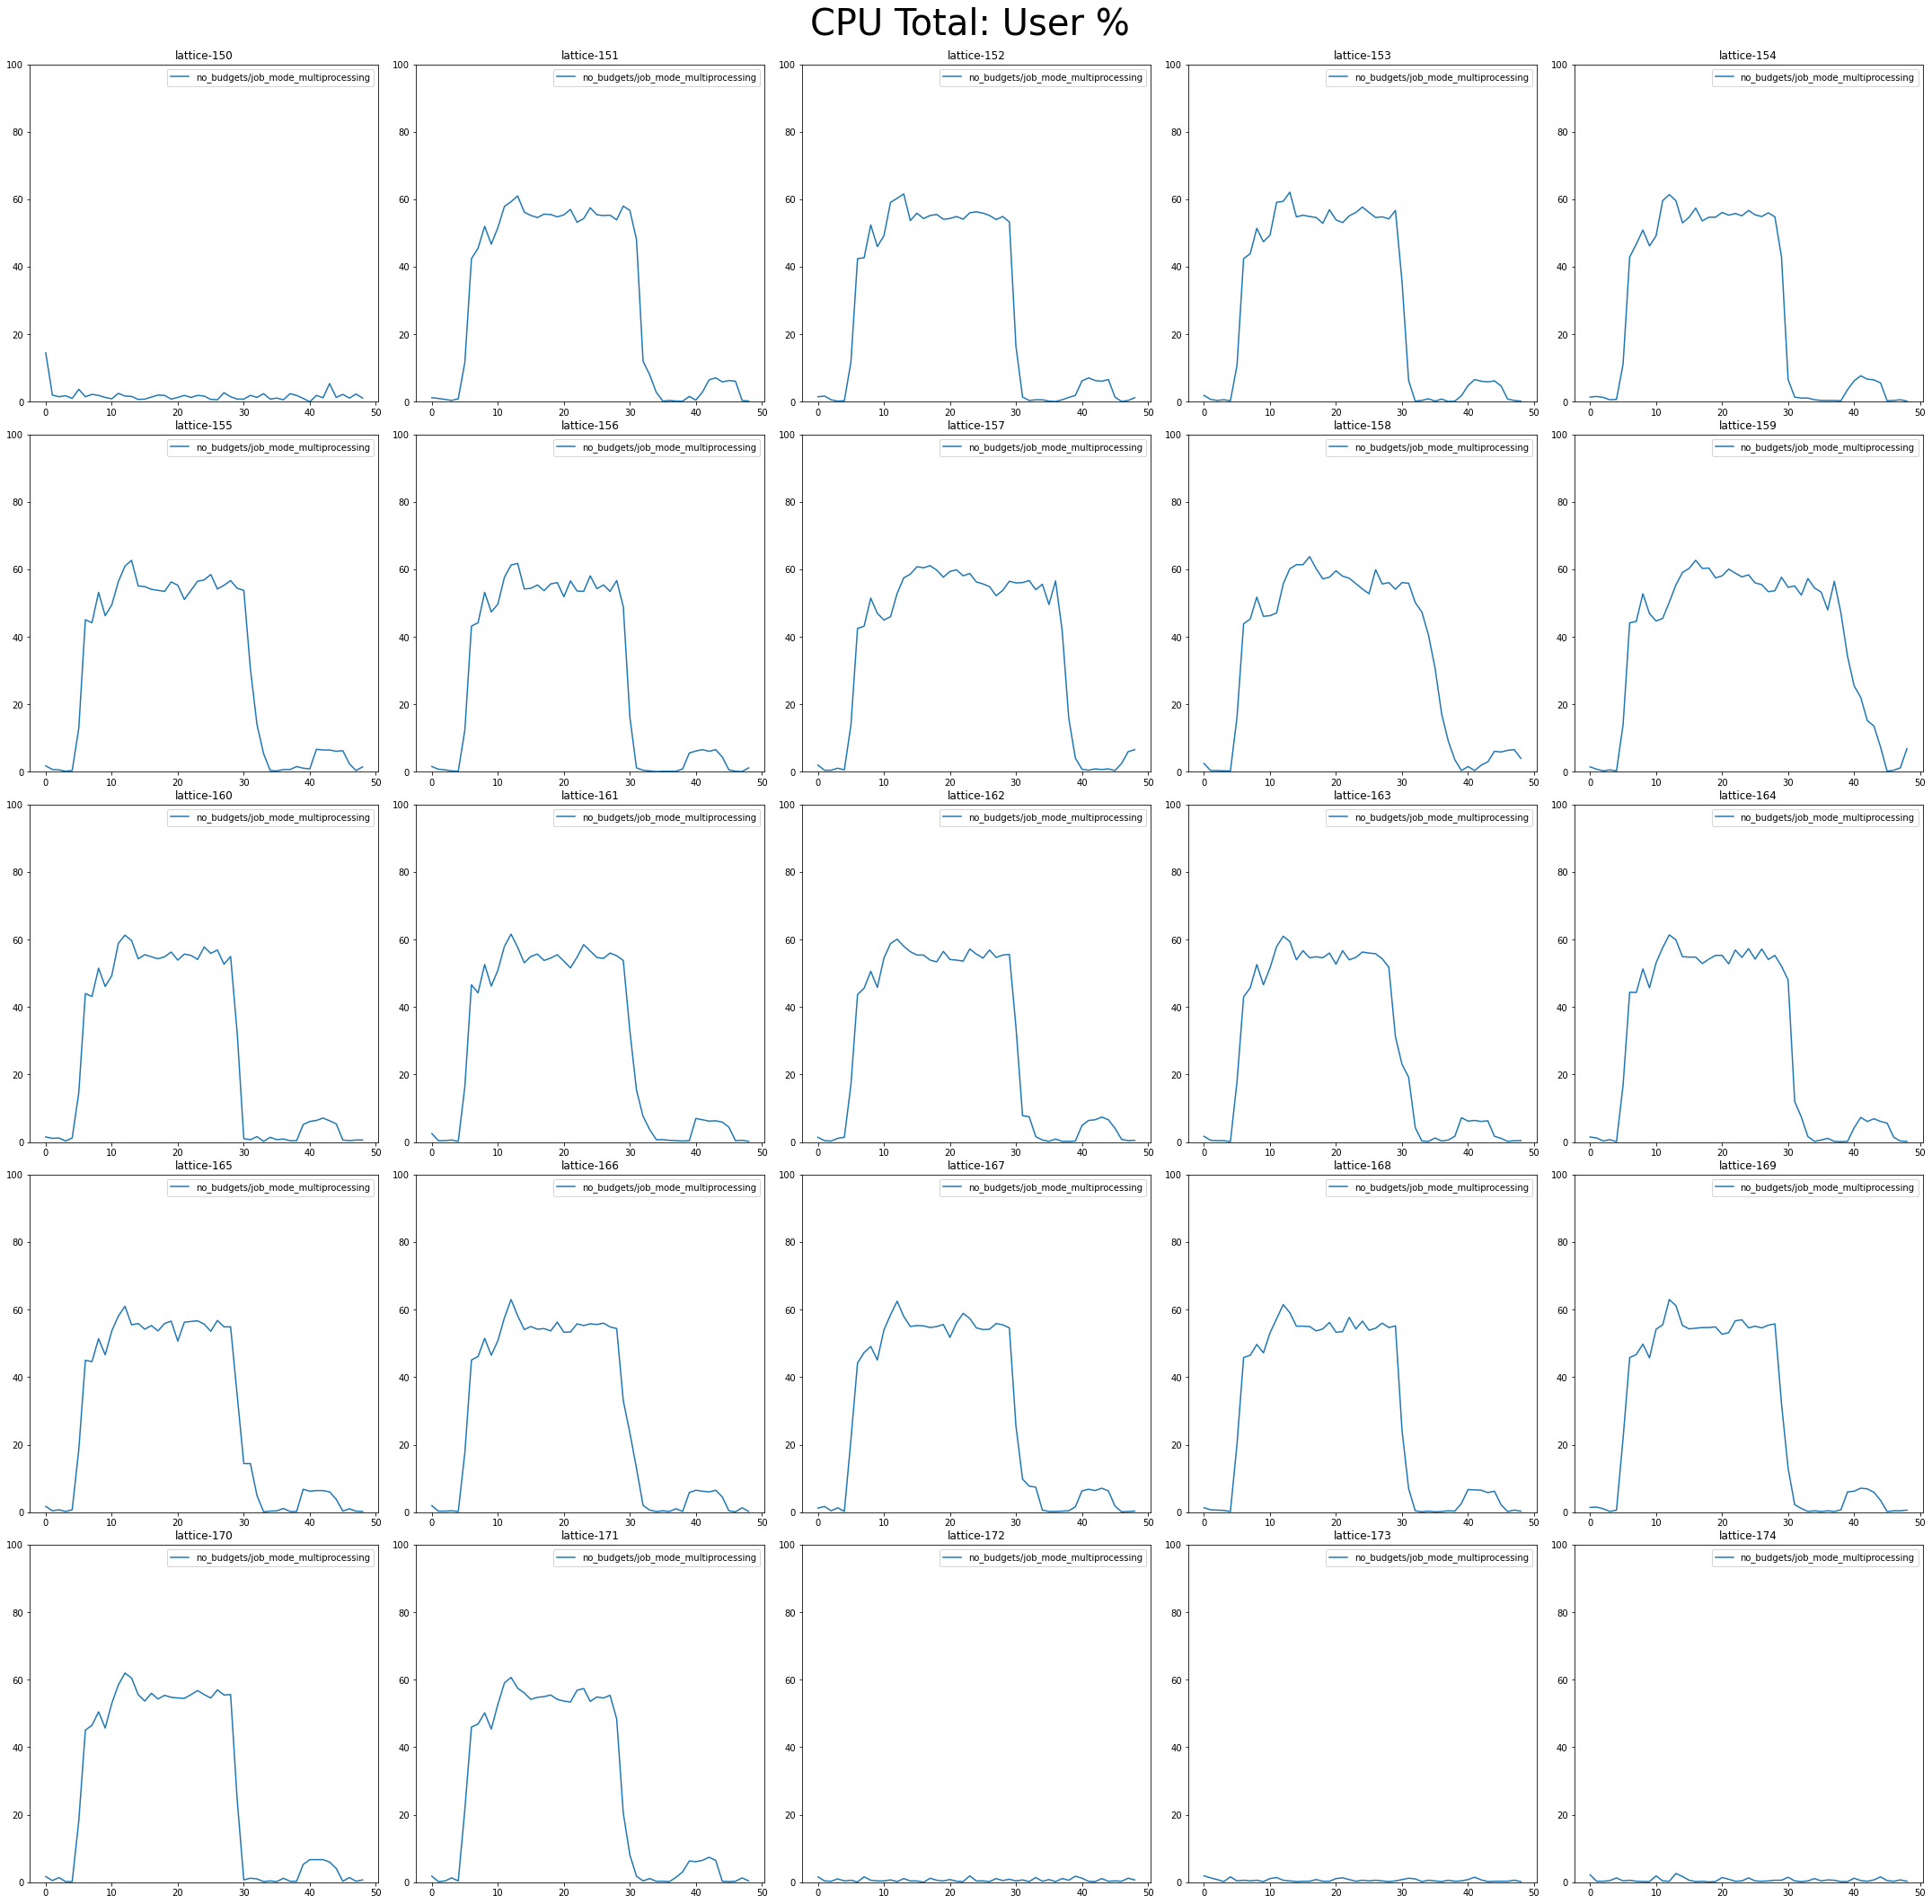

In [5]:
number_rows = 5
number_cols = 5

fig, ax = plt.subplots(nrows=number_rows, ncols=number_cols, figsize=(30, 30))
fig.tight_layout(h_pad=1.7)
fig.suptitle(metric_name, fontsize=40)

index = 0
for i in range(number_rows):
    for j in range(number_cols):
        for experiment, dataframe in experiment_dfs:
            ax[i,j].set_ylim(y_axis_limits)
            ax[i,j].plot(dataframe[index], label=experiment)
            ax[i,j].set_title(f"lattice-{150+index}")
            ax[i,j].legend()
        index += 1

plt.subplots_adjust(top=0.95)
plt.savefig(f"{experiments[0]}/cluster_statistics_{metric_file_suffix}.png", dpi=300)

### Response Plotting

Total response duration for no_budgets/job_mode_multiprocessing: 39.81095988070592 seconds


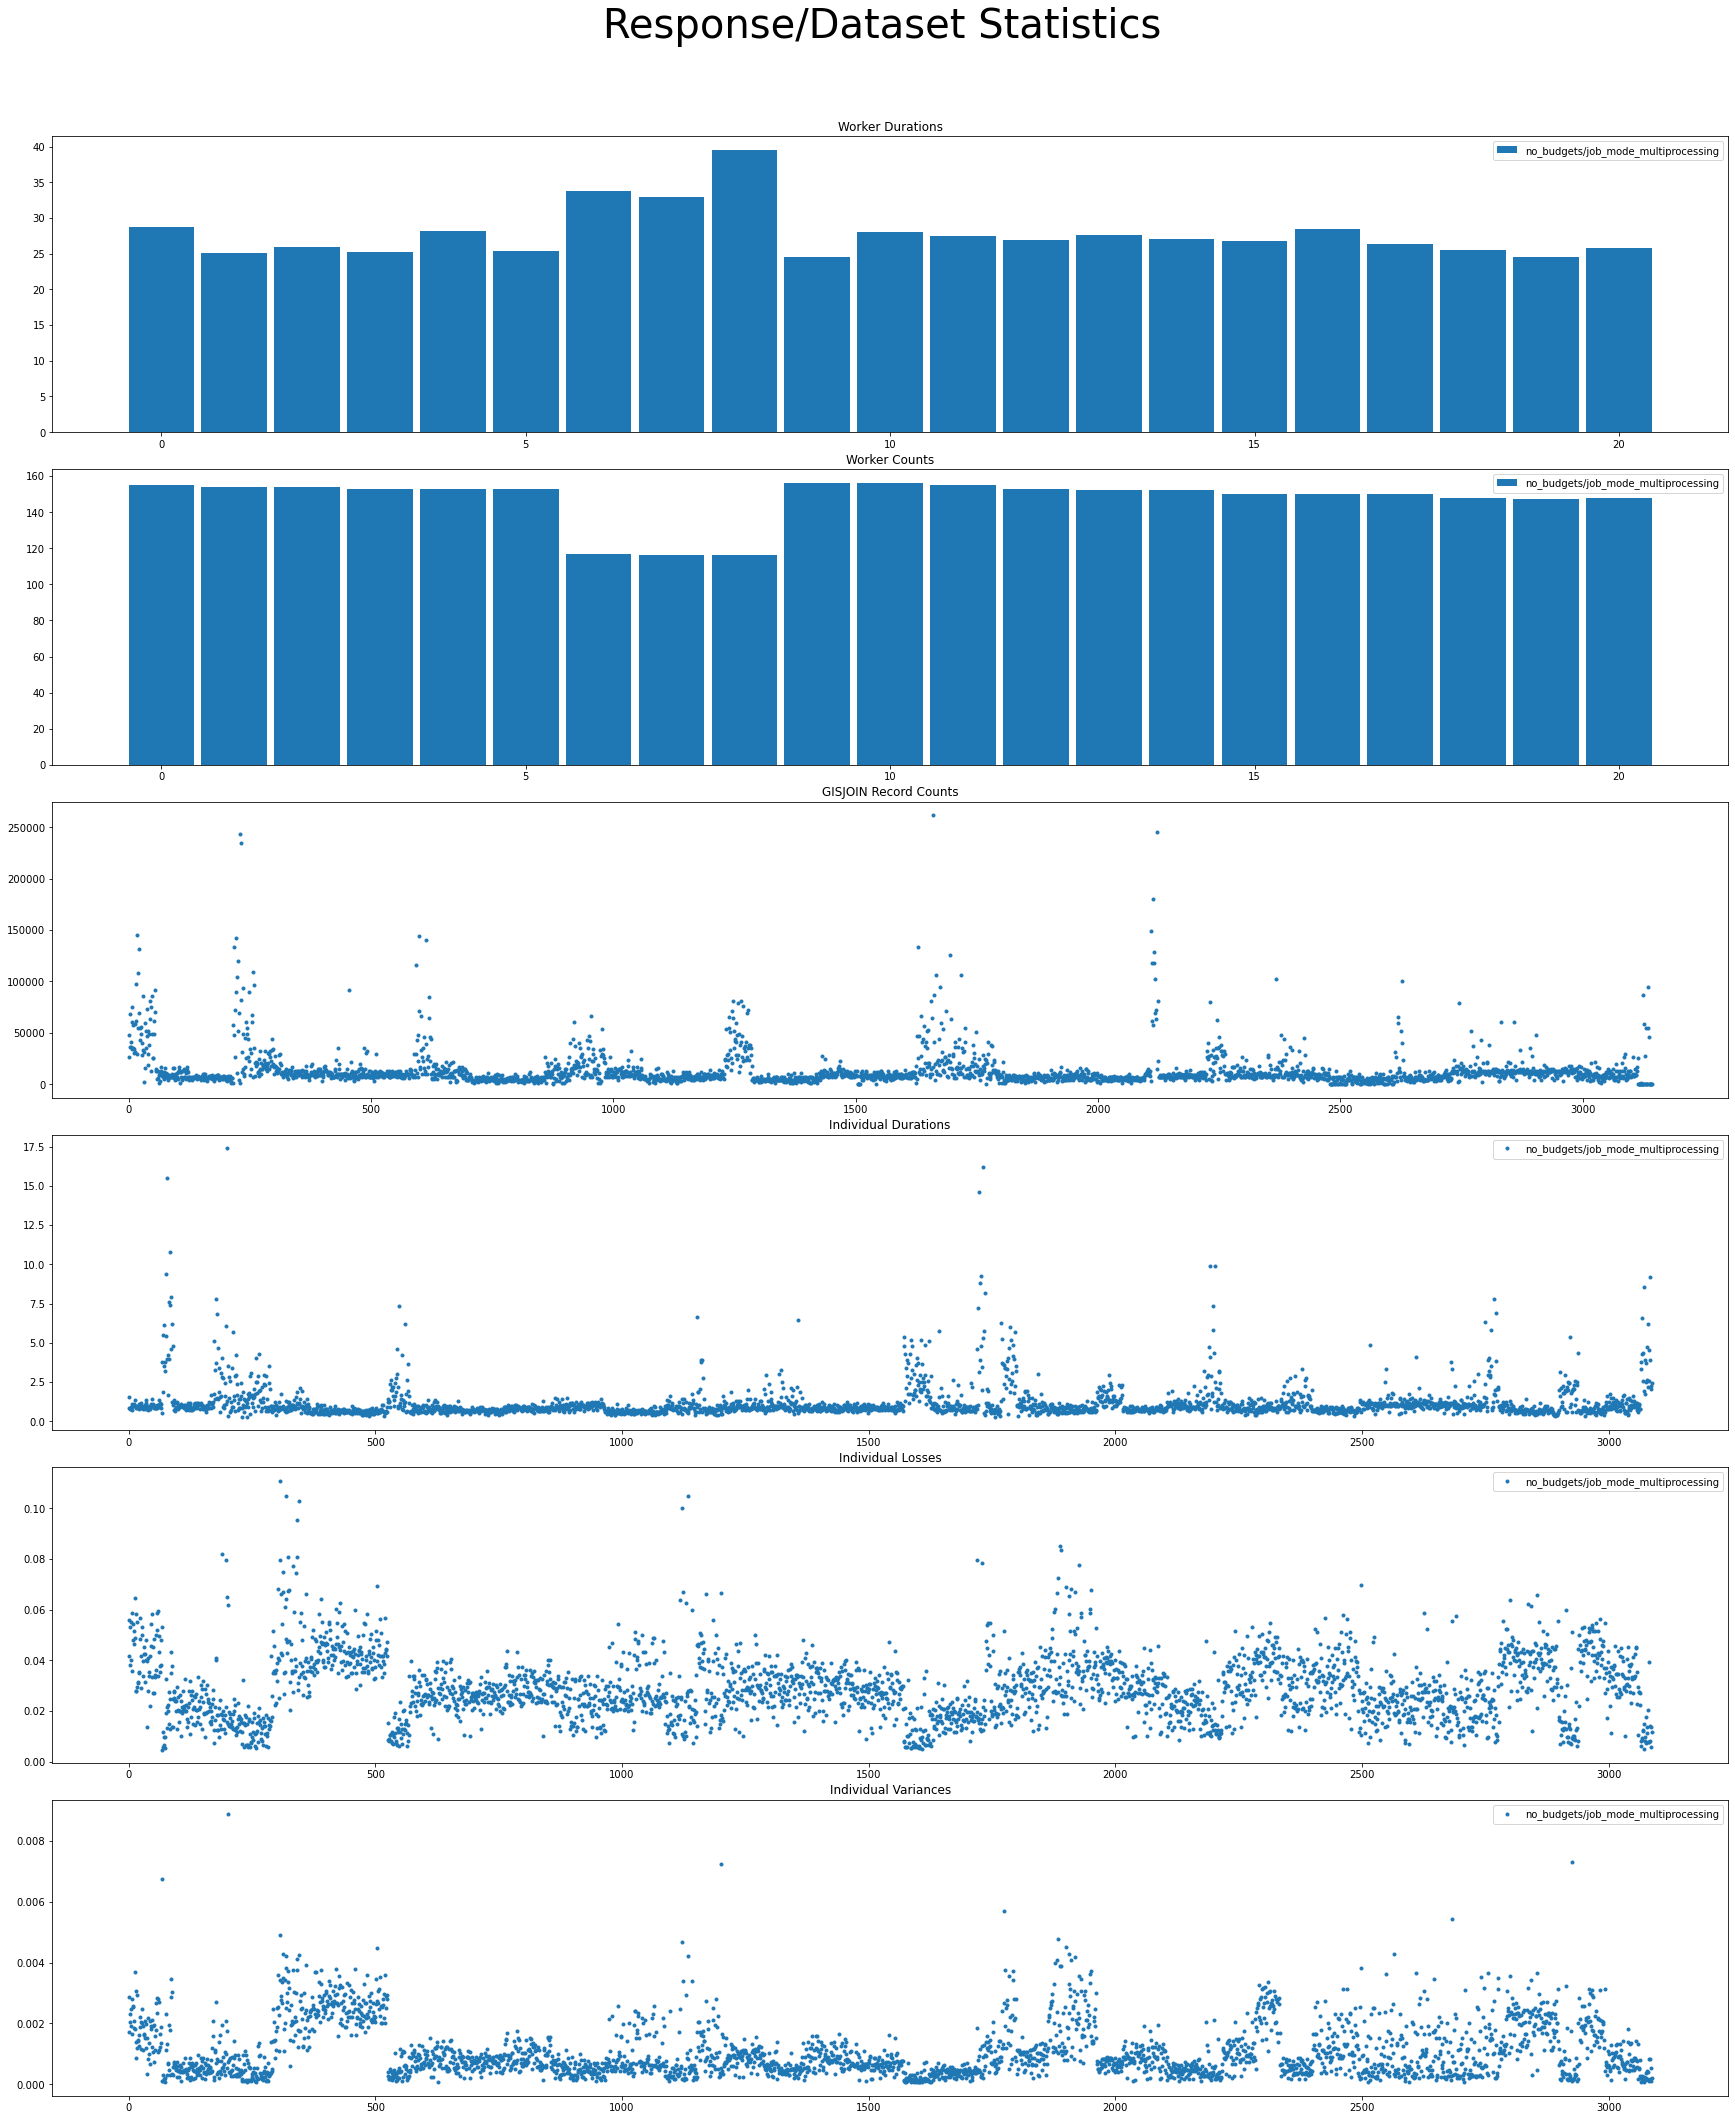

In [6]:
responses = []

for experiment in experiments:
    response_filename = f"{experiment}/response.json"
    with open(response_filename, "r") as response_file:
        responses.append((experiment, json.load(response_file)))

gis_join_count_filename = "../overlay/resources/gis_join_counts.json"

with open(gis_join_count_filename, "r") as f:
    gis_join_counts = json.load(f)

all_worker_counts = []
all_worker_durations = []
all_individual_durations = []
all_losses = []
all_variances = []

for experiment, response in responses:
    print(f"Total response duration for {experiment}: {response['duration_sec']} seconds")

    worker_durations = []
    worker_counts = []
    individual_durations = []
    individual_losses = []
    individual_variances = []
    for worker_response in response["worker_responses"]:
        worker_counts.append((worker_response["hostname"], len(worker_response["metrics"])))
        worker_durations.append((worker_response["hostname"], worker_response["duration_sec"]))
        for individual_metric in worker_response["metrics"]:
            if "duration_sec" in individual_metric.keys():
                individual_durations.append((individual_metric["gis_join"], individual_metric["duration_sec"]))
                individual_losses.append((individual_metric["gis_join"], individual_metric["loss"]))
                individual_variances.append((individual_metric["gis_join"], individual_metric["variance"]))

    individual_durations.sort(key=lambda y: y[0])
    all_individual_durations.append((experiment, [x[1] for x in individual_durations]))
    individual_losses.sort(key=lambda y: y[0])
    all_losses.append((experiment, [x[1] for x in individual_losses]))
    individual_variances.sort(key=lambda y: y[0])
    all_variances.append((experiment, [x[1] for x in individual_variances]))

    worker_durations.sort(key=lambda y: y[0])
    worker_durations_vals = [x[1] for x in worker_durations]
    worker_durations_names = [x[0][-3:] for x in worker_durations]
    all_worker_durations.append((experiment, worker_durations_names, worker_durations_vals))

    worker_counts.sort(key=lambda y: y[0])
    worker_counts_vals = [x[1] for x in worker_counts]
    worker_counts_names = [x[0][-3:] for x in worker_counts]
    all_worker_counts.append((experiment, worker_counts_names, worker_counts_vals))

number_rows = 6
number_cols = 1

fig, ax = plt.subplots(nrows=number_rows, ncols=number_cols, figsize=(24, 30))
fig.tight_layout(h_pad=1.9)
fig.suptitle("Response/Dataset Statistics", fontsize=40)
bar_width = 1.0/len(experiments) - 0.1

idx = 0
for worker_durations in all_worker_durations:
    x_axis = np.arange(len(worker_durations[1]))
    ax[0].bar(x_axis + idx * bar_width, worker_durations[2], width=bar_width, label=worker_durations[0])
    idx += 1
ax[0].set_title(f"Worker Durations")
ax[0].legend(loc="upper right")

idx = 0
for worker_counts in all_worker_counts:
    x_axis = np.arange(len(worker_counts[1]))
    ax[1].bar(x_axis + idx * bar_width, worker_counts[2], width=bar_width, label=worker_counts[0])
    idx += 1
ax[1].set_title(f"Worker Counts")
ax[1].legend(loc="upper right")

ax[2].set_title(f"GISJOIN Record Counts")
ax[2].plot(gis_join_counts.values(), '.')

for individual_durations in all_individual_durations:
    ax[3].plot(individual_durations[1], '.', label=individual_durations[0])
ax[3].set_title(f"Individual Durations")
ax[3].legend(loc="upper right")

for individual_losses in all_losses:
    ax[4].plot(individual_losses[1], '.', label=individual_losses[0])
ax[4].set_title(f"Individual Losses")
ax[4].legend(loc="upper right")

for individual_variances in all_variances:
    ax[5].plot(individual_variances[1], '.', label=individual_variances[0])
ax[5].set_title(f"Individual Variances")
ax[5].legend(loc="upper right")

plt.subplots_adjust(top=0.92)

plt.savefig(f"{experiments[0]}/response_dataset_statistics.png", dpi=300)

### Variance Budget Experiments

gis_join=G0100310, intermediate=0.030789342609218697, final=0.030789342609218697
gis_join=G0101290, intermediate=0.03323657226828895, final=0.03323657226828895
gis_join=G0201000, intermediate=0.08217429446297242, final=0.08217429446297242
gis_join=G0500370, intermediate=0.03718645873901151, final=0.03718645873901151
gis_join=G0100250, intermediate=0.025243363761201097, final=0.025243363761201097
gis_join=G0100550, intermediate=0.02378774723772041, final=0.02378774723772041
gis_join=G0500430, intermediate=0.04630678333402945, final=0.04630678333402945
gis_join=G0500870, intermediate=0.027700630870618033, final=0.027700630870618033
gis_join=G0501230, intermediate=0.034761530195859563, final=0.034761530195859563
gis_join=G0600830, intermediate=0.011733030741539729, final=0.011733030741539729
gis_join=G0600190, intermediate=0.007433920857174244, final=0.007433920857174244
gis_join=G0600530, intermediate=0.010408697510274324, final=0.010408697510274324
gis_join=G0500930, intermediate=0.0197

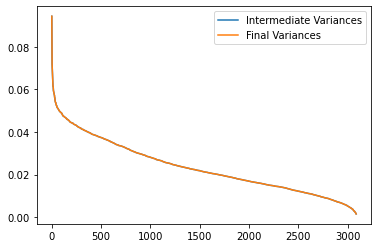

In [16]:
intermediate_response_filename = "variance_budgets/test/intermediate_response.json"
final_response_filename = "variance_budgets/test/response.json"

with open(intermediate_response_filename, "r") as f:
    intermediate_data = json.load(f)

with open(final_response_filename, "r") as f:
    final_data = json.load(f)

intermediate_variances = {}
for metric in intermediate_data["initial_response_metrics"]:
    intermediate_variances[metric["gis_join"]] = metric["variance"]

final_variances = {}
for worker_response in final_data["worker_responses"]:
    for metric in worker_response["metrics"]:
        final_variances[metric["gis_join"]] = metric["variance"]

for gis_join, final_variance in final_variances.items():
    print(f"gis_join={gis_join}, intermediate={intermediate_variances[gis_join]}, final={final_variance}")

sorted_intermediate_variances = sorted(list(intermediate_variances.values()), reverse=True)
sorted_final_variances = sorted(list(final_variances.values()), reverse=True)

plt.plot(sorted_intermediate_variances, label="Intermediate Variances")
plt.plot(sorted_final_variances, label="Final Variances")
plt.legend()
plt.show()